# Convolutional Neural Network pretrained on InceptionResNetV2 for Identifying the animal in image

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import keras
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
keras.utils.get_file('data.zip', 'https://s3-ap-southeast-1.amazonaws.com/he-public-data/DL%23+Beginner.zip')

6873530368/6873530111 [==============================] - 447s 0us/step


'/home/shivam/.keras/datasets/data.zip'

In [3]:
!cp ~/.keras/datasets/data.zip .
!zip -FF -fz data.zip --out temp.zip
!unzip temp.zip 
!mkdir data
!mv DL\#\ Beginner/* data/
!rmdir DL\#\ Beginner
!unzip data/meta-data.zip -d data/
!unzip -q data/test.zip -d data/
!zip -FF -fz data/train.zip --out temp.zip 
!unzip -q temp.zip -d data/

In [4]:
train = pd.read_csv('data/meta-data/train.csv')
test = pd.read_csv('data/meta-data/test.csv')
sample = pd.read_csv('data/meta-data/sample_submission.csv')

In [5]:
train.head()

,Image_id,Animal
0,Img-1.jpg,hippopotamus
1,Img-2.jpg,squirrel
2,Img-3.jpg,grizzly+bear
3,Img-4.jpg,ox
4,Img-5.jpg,german+shepherd


In [6]:
sample.head()

,image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,0.461052,0.160543,0.596985,0.112976,0.514793,0.795334,0.329462,0.956140,0.150305,...,0.097436,0.960740,0.586314,0.358086,0.632356,0.129911,0.970917,0.075613,0.891457,0.353058
1,Img-2.jpg,0.391038,0.015032,0.808050,0.229542,0.632174,0.557231,0.993525,0.392024,0.344499,...,0.980599,0.252298,0.882384,0.666060,0.404774,0.244035,0.319077,0.399242,0.282049,0.510206
2,Img-3.jpg,0.686004,0.862929,0.661918,0.725864,0.610226,0.463240,0.482999,0.377200,0.708358,...,0.763146,0.101021,0.725597,0.252975,0.804369,0.599251,0.300347,0.513784,0.337301,0.045477
3,Img-4.jpg,0.702411,0.557327,0.143711,0.693352,0.008305,0.807822,0.920738,0.446771,0.891311,...,0.406623,0.605928,0.085137,0.706568,0.325001,0.591561,0.246156,0.879007,0.130129,0.113896
4,Img-5.jpg,0.097772,0.376566,0.127358,0.713473,0.516010,0.548523,0.755888,0.428397,0.378050,...,0.152309,0.445195,0.466826,0.081746,0.180878,0.526940,0.838946,0.045366,0.001368,0.653959


In [7]:
class_to_animal = dict(enumerate(sample.keys()[1:]))
animal_to_class = {v: k for k, v in class_to_animal.items()}

### Move images into directories

In [8]:
import os
def move_to_dir(path, base_path, images):
    os.system('mkdir '+path)
    for i in images:
        os.system('mv '+base_path+i+' '+path+i)

In [9]:
test_images = np.array(test['Image_id'])
move_to_dir('./data/test/images/', './data/test/', test_images)

In [10]:
animal_dct = {i: [] for i in range(30)}
for i in np.array(train):
    animal_dct[animal_to_class[i[1]]].append(i[0])
from random import sample
!mkdir data/valid
for i in range(30):
    x = set(sample(animal_dct[i], int(len(animal_dct[i])*0.1)))
    y = set(animal_dct[i])-x
    move_to_dir('./data/train/'+class_to_animal[i]+'/', './data/train/', y)
    move_to_dir('./data/valid/'+class_to_animal[i]+'/', './data/train/', x)

### Default values for parameters

In [11]:
LEARNING_RATE = 0.00001
BATCH_SIZE = 40
DATASET_PATH = './data'
IMAGE_SIZE = (299, 299)
NUM_CLASSES = 30
FREEZE_LAYERS = 2
WEIGHTS_DIR = './weights-InceptionResNetV2.h5'
NUM_EPOCHS = 10
SEED = 42

### Set random seed 

In [12]:
np.random.seed(SEED)

### Sample images

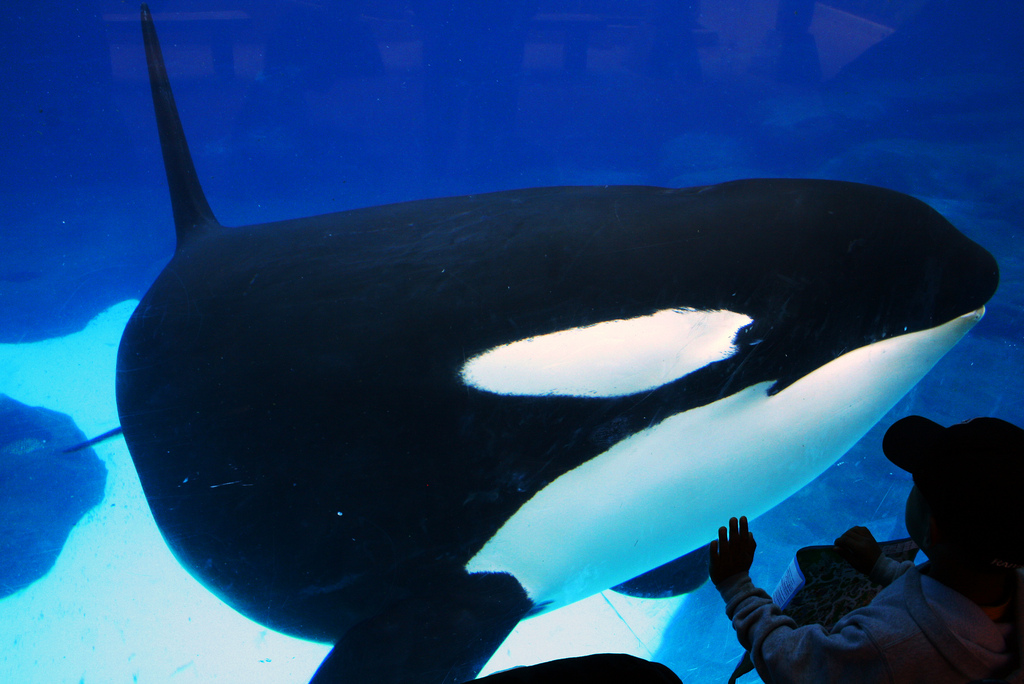

In [13]:
Image.open('./data/test/images/Img-62.jpg')

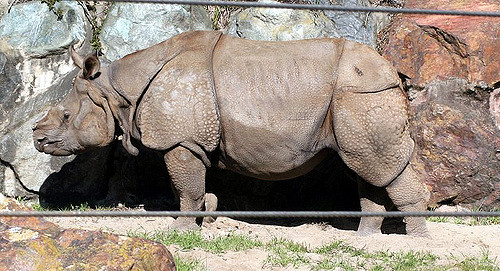

In [14]:
Image.open('./data/train/rhinoceros/Img-10002.jpg')

### Define the CNN model

In [15]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

### Compile and train the model

In [16]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 11714 images belonging to 30 classes.
Found 1286 images belonging to 30 classes.


### Build the classifier model based on pre-trained ResNet50

In [17]:
net = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None,
                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)

219062272/219055592 [==============================] - 5s 0us/step


In [18]:
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

In [19]:
net_final.compile(optimizer=Adam(lr=LEARNING_RATE),
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
net_final.fit_generator(train_generator,
                        steps_per_epoch = train_generator.samples // BATCH_SIZE,
                        validation_data = valid_generator,
                        validation_steps = valid_generator.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

Epoch 1/10
292/292 [==============================] - 1153s 4s/step - loss: 1.4851 - acc: 0.6256 - val_loss: 0.3285 - val_acc: 0.9063
Epoch 2/10
292/292 [==============================] - 1064s 4s/step - loss: 0.4923 - acc: 0.8593 - val_loss: 0.2526 - val_acc: 0.9313
Epoch 3/10
292/292 [==============================] - 1085s 4s/step - loss: 0.3651 - acc: 0.8952 - val_loss: 0.2293 - val_acc: 0.9359
Epoch 4/10
292/292 [==============================] - 1070s 4s/step - loss: 0.2976 - acc: 0.9118 - val_loss: 0.1986 - val_acc: 0.9375
Epoch 5/10
292/292 [==============================] - 1075s 4s/step - loss: 0.2553 - acc: 0.9229 - val_loss: 0.1892 - val_acc: 0.9484
Epoch 6/10
292/292 [==============================] - 1083s 4s/step - loss: 0.2180 - acc: 0.9341 - val_loss: 0.1831 - val_acc: 0.9484
Epoch 7/10
292/292 [==============================] - 1081s 4s/step - loss: 0.1942 - acc: 0.9405 - val_loss: 0.1735 - val_acc: 0.9469
Epoch 8/10
292/292 [==============================] - 1068s 4s

In [21]:
net_final.save(WEIGHTS_DIR)

In [22]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode=None,
                                                  shuffle=False,
                                                  batch_size=1)

Found 6000 images belonging to 1 classes.


In [23]:
test_generator.reset()
pred = net_final.predict_generator(test_generator, verbose=1)

6000/6000 [==============================] - 708s 118ms/step


In [24]:
labels = train_generator.class_indices

In [25]:
pred.shape

(6000, 30)

In [26]:
filenames = test_generator.filenames
results = pd.read_csv('data/meta-data/sample_submission.csv')

In [27]:
results.head()

,image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,0.461052,0.160543,0.596985,0.112976,0.514793,0.795334,0.329462,0.956140,0.150305,...,0.097436,0.960740,0.586314,0.358086,0.632356,0.129911,0.970917,0.075613,0.891457,0.353058
1,Img-2.jpg,0.391038,0.015032,0.808050,0.229542,0.632174,0.557231,0.993525,0.392024,0.344499,...,0.980599,0.252298,0.882384,0.666060,0.404774,0.244035,0.319077,0.399242,0.282049,0.510206
2,Img-3.jpg,0.686004,0.862929,0.661918,0.725864,0.610226,0.463240,0.482999,0.377200,0.708358,...,0.763146,0.101021,0.725597,0.252975,0.804369,0.599251,0.300347,0.513784,0.337301,0.045477
3,Img-4.jpg,0.702411,0.557327,0.143711,0.693352,0.008305,0.807822,0.920738,0.446771,0.891311,...,0.406623,0.605928,0.085137,0.706568,0.325001,0.591561,0.246156,0.879007,0.130129,0.113896
4,Img-5.jpg,0.097772,0.376566,0.127358,0.713473,0.516010,0.548523,0.755888,0.428397,0.378050,...,0.152309,0.445195,0.466826,0.081746,0.180878,0.526940,0.838946,0.045366,0.001368,0.653959


In [28]:
for i in zip(results['image_id'], range(0, 6000)):
    idx = filenames.index('images/'+i[0])
    results.iloc[i[1], 1:] = pred[idx]

In [29]:
results.head()

,image_id,antelope,bat,beaver,bobcat,buffalo,chihuahua,chimpanzee,collie,dalmatian,...,raccoon,rat,rhinoceros,seal,siamese+cat,spider+monkey,squirrel,walrus,weasel,wolf
0,Img-1.jpg,1.329025e-07,0.000002,2.804242e-07,6.910639e-07,9.999344e-01,5.470731e-08,1.395037e-06,2.253882e-07,4.855321e-08,...,1.466760e-07,1.727133e-07,4.611464e-06,3.216527e-07,2.906769e-08,1.316715e-07,2.101895e-07,1.153326e-07,2.994435e-07,1.455696e-07
1,Img-2.jpg,3.445175e-04,0.013845,1.762734e-05,2.067606e-03,5.025806e-05,1.385663e-03,7.260278e-04,8.770903e-04,7.260693e-05,...,2.889932e-03,5.013410e-04,2.565223e-03,6.306609e-04,1.930685e-01,2.262766e-04,1.337359e-02,6.045130e-04,2.082241e-04,7.943684e-04
2,Img-3.jpg,3.931411e-04,0.005374,1.790700e-03,2.347508e-04,9.013598e-02,1.280213e-03,1.861169e-03,1.107409e-03,2.292344e-04,...,2.350107e-03,5.474941e-03,4.836589e-01,1.784164e-03,2.111983e-04,1.072349e-04,1.055997e-03,1.543694e-04,5.053639e-04,2.565375e-03
3,Img-4.jpg,4.608623e-07,0.000002,3.234436e-07,7.864328e-08,2.841294e-07,2.124297e-06,2.781471e-06,5.634316e-07,1.135855e-07,...,9.996638e-01,1.826502e-06,3.908399e-08,2.308696e-07,4.823617e-07,1.369857e-06,4.271812e-06,1.220858e-07,2.780458e-04,3.004562e-07
4,Img-5.jpg,4.143241e-08,0.001609,9.007606e-05,8.051920e-09,2.851290e-06,1.716989e-07,3.677333e-07,1.638135e-07,5.524088e-08,...,3.316092e-06,1.906592e-04,4.951267e-09,1.773226e-07,5.334130e-08,1.202477e-08,2.090069e-06,1.250328e-06,2.959198e-06,1.767460e-07


In [30]:
results.to_csv('results_InceptionResNetV2.csv', index=False)

### References

1. https://www.hackerearth.com/challenge/competitive/deep-learning-beginner-challenge/